In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import math
from PIL import Image
from torchsummary import summary
from numpy import asarray


In [6]:

image_dir = "../data/gkao/Images"
SAVE_DIR = "./content/Results"
piece_dir = {}
batch_size = 128
image_size = (128, 128)  # Subject to change
epochs = 50



In [7]:

def popPeiceDir():
    for dir in os.listdir(image_dir):
        if dir.startswith('.'):
            continue
        piece_dir[dir] = os.path.join(image_dir, dir)


popPeiceDir()

In [9]:
piece_dir

{'BR': '../data/gkao/Images/BR',
 'Testimg': '../data/gkao/Images/Testimg',
 'BKi': '../data/gkao/Images/BKi',
 'Empty': '../data/gkao/Images/Empty',
 'WB': '../data/gkao/Images/WB',
 'WP': '../data/gkao/Images/WP',
 'WR': '../data/gkao/Images/WR',
 'BQ': '../data/gkao/Images/BQ',
 'WQ': '../data/gkao/Images/WQ',
 'WKi': '../data/gkao/Images/WKi',
 'Testimg2': '../data/gkao/Images/Testimg2',
 'BK': '../data/gkao/Images/BK',
 'BP': '../data/gkao/Images/BP',
 'BB': '../data/gkao/Images/BB',
 'WK': '../data/gkao/Images/WK'}

In [10]:

# Empty Square = 0, Pawn = 1, King = 2, Queen = 3, Rook = 4, Bishop = 5, Knight = 6
def getFilesAndLabels():
    fl = []
    for key in piece_dir:
        if key == "Testimg" or key == "Testimg2":
            continue
        for file in os.listdir(piece_dir[key]):
            if file.startswith('.'):
                continue
            label = -1
            if key == "BB" or key == "WB":
                label = 5
            if key == "BK" or key == "WK":
                label = 6
            if key == "BKi" or key == "WKi":
                label = 2
            if key == "BP" or key == "WP":
                label = 1
            if key == "BQ" or key == "WQ":
                label = 3
            if key == "BR" or key == "WR":
                label = 4
            if key == "Empty":
                label = 0
            assert label != -1
            fl.append([os.path.join(piece_dir[key], file), label])
    return fl



In [156]:
def transformImg(img):
    preproc = transforms.Compose([transforms.Grayscale(),
                                  transforms.Resize(image_size), transforms.ToTensor(),
                                  transforms.Normalize((0.2805,), (0.1946,))
                                 ]
                                )
    return preproc(img)


In [12]:

def getArr(image_path):
    img = Image.open(image_path)
    img = transformImg(img)
    return img


In [13]:
data = getFilesAndLabels()

In [15]:
data

[['../data/gkao/Images/BR/20160529_214739.jpg', 4],
 ['../data/gkao/Images/BR/20160529_235020.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214720.jpg', 4],
 ['../data/gkao/Images/BR/IMG_20180427_095206.jpg', 4],
 ['../data/gkao/Images/BR/IMG_20180427_095239.jpg', 4],
 ['../data/gkao/Images/BR/IMG_20180427_095218.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214848.jpg', 4],
 ['../data/gkao/Images/BR/IMG_20180427_095220.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214903.jpg', 4],
 ['../data/gkao/Images/BR/20160529_235028.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214717.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214840.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214934.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214814.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214726.jpg', 4],
 ['../data/gkao/Images/BR/20160529_214719.jpg', 4],
 ['../data/gkao/Images/BR/IMG_20180427_095231.jpg', 4],
 ['../data/gkao/Images/BR/IMG_20180427_101633.jpg', 4],
 ['../data/gkao/Images/BR/IMG_20180427_0

In [16]:
class DataSet(Dataset):
    def __init__(self, files_labels):
        self.fl = files_labels
        self.count = 0

    def __len__(self):
        return len(self.fl)

    def __getitem__(self, index):
        img_arr = getArr(self.fl[index][0])
        #label = torch.tensor([0, 0, 0, 0, 0, 0, 0])
        #label[self.fl[index][1]] = 1
        label = self.fl[index][1]
        return img_arr.float(), label


In [17]:
dataset = DataSet(data)

In [88]:
dataset[0][0].reshape((128, 128, 3))

tensor([[[0.2118, 0.2078, 0.2157],
         [0.2235, 0.2196, 0.2196],
         [0.2196, 0.2275, 0.1765],
         ...,
         [0.2235, 0.2196, 0.2157],
         [0.2157, 0.2196, 0.2157],
         [0.2157, 0.2039, 0.2157]],

        [[0.2000, 0.2000, 0.2078],
         [0.2118, 0.2039, 0.2078],
         [0.2039, 0.2235, 0.1490],
         ...,
         [0.2235, 0.2235, 0.2275],
         [0.2196, 0.2196, 0.2196],
         [0.2196, 0.2118, 0.2196]],

        [[0.2078, 0.2118, 0.2157],
         [0.2118, 0.2078, 0.2039],
         [0.2275, 0.2235, 0.2471],
         ...,
         [0.2275, 0.2196, 0.2196],
         [0.2196, 0.2196, 0.2196],
         [0.2157, 0.2196, 0.2196]],

        ...,

        [[0.2275, 0.2157, 0.2235],
         [0.2118, 0.2118, 0.2118],
         [0.2235, 0.2157, 0.2157],
         ...,
         [0.1608, 0.1647, 0.1569],
         [0.1686, 0.1686, 0.1608],
         [0.1490, 0.1373, 0.2627]],

        [[0.2314, 0.2235, 0.2196],
         [0.2118, 0.2235, 0.2157],
         [0.

In [149]:
dataset[301][0]

tensor([[[0.7569, 0.7490, 0.7216,  ..., 0.7294, 0.7294, 0.7294],
         [0.7490, 0.7412, 0.7176,  ..., 0.7255, 0.7255, 0.7255],
         [0.7529, 0.7451, 0.7059,  ..., 0.7255, 0.7255, 0.7255],
         ...,
         [0.1647, 0.3765, 0.7059,  ..., 0.6196, 0.2431, 0.1804],
         [0.1608, 0.3922, 0.7098,  ..., 0.6588, 0.3059, 0.1765],
         [0.1686, 0.4000, 0.7059,  ..., 0.5059, 0.2941, 0.1843]]])

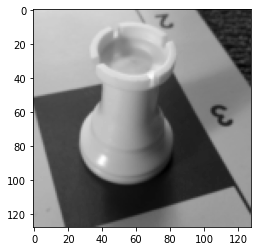

In [115]:
img = Image.open(data[300][0])

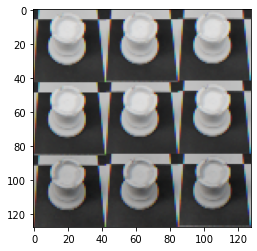

In [131]:
pyplot.imshow(transforms.ToTensor()(transforms.Resize((128, 128))(img)).view(128, 128, 3))

In [147]:
np.asarray(transforms.Resize((128, 128))(img)).reshape((3, 128, 128))

array([[[ 41,  43,  42, ..., 175, 190, 188],
        [175, 190, 188, ..., 189, 177, 192],
        [188, 176, 192, ...,  38,  37,  33],
        ...,
        [211, 184, 214, ..., 196, 189, 177],
        [186, 182, 171, ..., 149, 203, 200],
        [155, 207, 204, ..., 211, 184, 213]],

       [[210, 183, 214, ..., 194, 186, 174],
        [185, 181, 170, ..., 156, 205, 203],
        [163, 209, 207, ..., 211, 186, 212],
        ...,
        [170, 199, 193, ..., 156, 122, 153],
        [146, 114,  97, ..., 195, 185, 173],
        [194, 187, 178, ..., 171, 199, 193]],

       [[170, 199, 193, ..., 145, 113, 113],
        [107,  85,  56, ..., 196, 186, 174],
        [193, 186, 178, ..., 167, 198, 192],
        ...,
        [ 94,  88,  88, ...,  90, 102,  98],
        [ 89, 108, 104, ...,  87,  76,  95],
        [ 89,  78,  94, ..., 117, 106, 100]]], dtype=uint8)

In [168]:

# Starting Image dims, Maxpooling Kernal, number of times maxpool is called in CNN, number of conv channels
def findFCFeatures(images_size, maxpooling, num_maxpool, num_channels):
    x, y = images_size
    mx, my = maxpooling
    for i in range(num_maxpool):
        x = math.floor(((x - (mx - 1) - 1) / mx) + 1)
        y = math.floor(((y - (my - 1) - 1) / my) + 1)
    return x * y * num_channels


def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.LeakyReLU(inplace=True))


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_down1 = double_conv(1, 32)
        self.conv_down2 = double_conv(32, 64)
        self.conv_down3 = double_conv(64, 128)
        self.conv_down4 = double_conv(128, 256)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(findFCFeatures(image_size, (2, 2), 3, 256), 7)

    def forward(self, x):
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.conv_down4(x)
        x = x.view(-1, findFCFeatures(image_size, (2, 2), 3, 256))
        x = self.fc1(x)
        return x


In [169]:
model = Net()

In [174]:


tess = math.floor(len(data) * 0.2)
trss = len(data) - tess

train_subsamples, test_subsamples = torch.utils.data.random_split(range(len(data)), [trss, tess])


In [175]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=0, sampler=train_subsamples)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=0, sampler=test_subsamples)

In [178]:
inp, label = next(iter(test_loader))

In [182]:
cur_pre = model(inp)

In [183]:
test_num_correct = 0
for i in range(cur_pre.shape[0]):
    if label[i] == torch.argmax(cur_pre[i]):
        test_num_correct += 1

In [184]:
test_num_correct

20

In [189]:
test_num_correct / len(label)

0.15625